# Inter-Stellar Medium (ISM) tutorial 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We define a function for formatting the axes' ticks:

In [2]:
def format_axes_ticks(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelsize=14)

The `galapy.InterStellarMedium` module defines classes and functions for modelling the gas and dust components impact on the total spectrum of a galaxy.

It can be imported via:

In [3]:
import galapy.InterStellarMedium as gpism

Or called from the global namespace of the library:

```python
>>> import galapy as gp
>>> gp.InterStellarMedium
<module 'galapy.InterStellarMedium' from '/path/to/installed/version/of/galapy/InterStellarMedium.py'>
```

An object of type `ISM` is instantiated via

In [4]:
ism = gpism.ISM()

In `galapy`, the ISM is modelled as a medium constituted of two phases, a **Molecular Cloud** (MC) component, embedding star-forming regions, and a **Diffuse Dust** (DD) component which is roughly considered as a *spherical* region centred at the centre of the galaxy.

The emission from stars has to first exit the MCs and then escape the dusty diffuse region. The attenuation from the two regions is therefore not independed as only the light escaping from MCs is then attenuated by the DD region.

Let us define some useful quantities:

* Wavelength grid:

In [5]:
ll = np.logspace( 0, 10, 300 )

* Luminosity unit

In [6]:
Lsun = 3.828e+33

The default parameters of the model can be printed by calling the dedicated function of the module:

* **Molecular-Clouds**: key = `'mc'`

In [7]:
gpism.ism_build_params(phase='mc')

{'f_MC': 0.5,
 'norm_MC': 100.0,
 'N_MC': 1000.0,
 'R_MC': 10.0,
 'Zgas': 0.5,
 'tau_esc': 10000000.0,
 'Mgas': 1000000000.0}

* **Diffuse-Dust**: key = `dd`

In [8]:
gpism.ism_build_params(phase='dd')

{'f_MC': 0.5,
 'norm_DD': 1.0,
 'Mdust': 10000000.0,
 'Rdust': 1000.0,
 'f_PAH': 0.2}

Notice that the two parameter dictionaries share the key-value pair `'f_MC' = 0.5` which regulates the relative contribution of the two components to the overall attenuation in terms of the fraction contributed by the Molecular-Clouds only (i.e. in this case, $50\%$).

\[Parameterizing in terms of a single component prevents the user to accidentally set values whose sum is greater than 1\]

Let's go through some of the main quantities that can be retrieved with the `ISM` type.

### ISM Emission

This quantity is approximated with a grey-body emission depending on the model parameters and on the temperature of the medium. The latter quantity has to be set by the user by calling the dedicated function (the argument is assumed in units of Kelvin):

In [9]:
ism.mc.set_temperature( 30 )
ism.dd.set_temperature( 38 )

the emission of the two different components at varying wavelength can then be obtained with the function

In [10]:
Lmc = ism.mc.emission(ll)
Ldd = ism.dd.emission(ll)

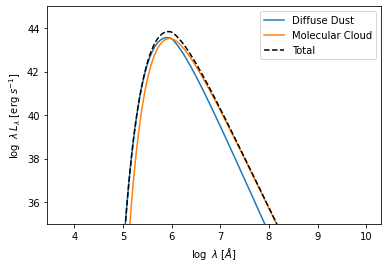

In [11]:
plt.ylim(35,45)
plt.xlabel( '$\\log\\ \\lambda\\ [\\AA]$' )
plt.ylabel( '$\\log\\ \\lambda\\; L_\\lambda\\ [$erg$\\; s^{-1}]$' )
plt.plot( np.ma.log10( ll ), np.ma.log10( ll * Lsun * Ldd ), label='Diffuse Dust' )
plt.plot( np.ma.log10( ll ), np.ma.log10( ll * Lsun * Lmc ), label='Molecular Cloud' )
plt.plot( np.ma.log10( ll ), np.ma.log10( ll * Lsun * (Ldd+Lmc) ), label='Total', c='k', ls='--', lw=1.5 )
_ = plt.legend()

### Attenuation

In [12]:
Amc = ism.mc.attenuation(ll)
Add = ism.dd.attenuation(ll)

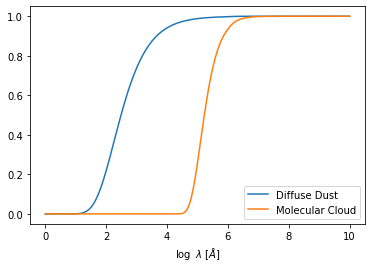

In [13]:
plt.xlabel( '$\\log\\ \\lambda\\ [\\AA]$' )
plt.plot( np.ma.log10( ll ), Add, label='Diffuse Dust' )
plt.plot( np.ma.log10( ll ), Amc, label='Molecular Cloud' )
_ = plt.legend()

### Extinction

We compute this quantity in units of its value in the visible-band 

In [14]:
Extmc = ism.mc.extinction(ll) / ism.mc.A_V()
Extdd = ism.dd.extinction(ll) / ism.dd.A_V()

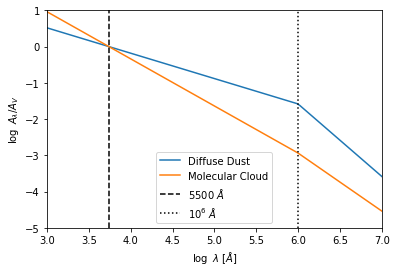

In [15]:
plt.xlim(3,7)
plt.ylim(-5,1)
plt.xlabel( '$\\log\\ \\lambda\\ [\\AA]$' )
plt.ylabel( '$\\log\\ A_\\lambda/A_V$' )
plt.plot( np.ma.log10( ll ), np.ma.log10( Extdd ), label='Diffuse Dust' )
plt.plot( np.ma.log10( ll ), np.ma.log10( Extmc ), label='Molecular Cloud' )
plt.axvline( np.log10(5500), c='k', ls='--', label='$5500\\ \\AA$' )
plt.axvline( 6, c='k', ls=':', label = '$10^6\\ \\AA$')
_ = plt.legend()

### Total attenuation

As this quantity depends on the time spent by the photons within the molecular cloud through the parameter `tau_esc`, it is a function of time.

In [16]:
t_esc = ism.mc.params['tau_esc']
tunit = np.logspace( np.log10(.8), np.log10(4), 100 ) # time array in units of tau_esc
tt = tunit * t_esc                                    # time array in unit of [yr]

The function `total_attenuation` of the `ISM` class returns a tuple with 2 matrices, of shape `(len(ll), len(tt))` where `ll` is the wavelength grid and `tt` the time grid, containing the contribute to attenuation from MC-only and the global attenuation itself.

In [17]:
attTotMC, attTot = ism.total_attenuation( ll, tt )
attTotMC = attTotMC.reshape(ll.size, tt.size)
attTot   = attTot.reshape(ll.size, tt.size)

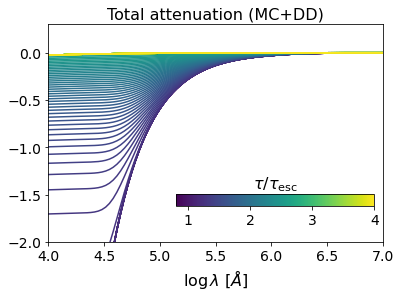

In [18]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots( 1,1 )

# Plot
ax.set_xlim( 4, 7 )
ax.set_ylim( -2, 0.3 )
ax.set_prop_cycle( color=plt.cm.viridis(np.linspace(0.01,0.99,len(tt))) )
ax.set_xlabel( '$\\log \\lambda\\ [\\AA]$', fontsize = 16 )
#ax.set_ylabel( '$\\log\\ S_\\nu\\ [m\\,\\mathrm{Jy}]$', fontsize = 16 )
ax.set_title("Total attenuation (MC+DD)", fontsize=16)
for _t, _a in zip( tunit, attTot.T ) :
    ax.plot(np.ma.log10( ll ), np.ma.log10( _a ) )
        
# Color-map
cmap = plt.cm.viridis
norm = Normalize( vmin=np.min(tunit), vmax=np.max(tunit) ) # normalization
cax = fig.add_axes([0.42, 0.25, 0.46, 0.04])               # position
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cax, 
                    orientation='horizontal', 
                    ticks=[1, 2, 3, 4])
_ = cbar.ax.set_title( "$\\tau / \\tau_\\mathrm{esc}$", fontsize=16)

# Formatting
format_axes_ticks(fig)